In [259]:
import uproot
import numpy as np


In [260]:
file1 = uproot.open("dane/700493_mcA_2.root")
file2 = uproot.open("dane/700493_mcD_2.root")
file3 = uproot.open("dane/700493_mcE_2.root")

In [261]:
branches1 = file1['nominal'].arrays(library="np")
branches2 = file2['nominal'].arrays(library="np")
branches3 = file3['nominal'].arrays(library="np")

In [262]:
len(branches1)

90

In [263]:
len(branches2)

90

In [264]:
combined_data = {}

In [265]:
keys = list(branches1)

In [266]:
for i in keys:
    combo = np.concatenate([branches1[i], branches2[i], branches3[i]])
    combined_data[i] = combo

In [267]:
def minus_value_filter(keys, branch):
    for key in keys:
        min = np.min(branch[key])
        max = np.max(branch[key])
        distance = abs(max - min)
        for i in range(len(branch[key])):
            branch[key][i] = branch[key][i] + distance
    return branch 

In [268]:
def norm(keys, branch):
    
    maxes = {}
    mins = {}
    
    for key in keys:
        max = np.max(branch[key])
        min = np.min(branch[key])
        
        
        for i in range(len(branch[key])):
            if max != 0:
                branch[key][i] = branch[key][i] / max
        if(max != 0):
            maxes[key] = max / max    
            mins[key] = min / max
        
        
    return [branch, maxes, mins]

In [269]:
a = norm(keys, combined_data)

In [271]:
import matplotlib.pyplot as plt

In [272]:
def bins(n, list):
    bins = []
    
    list = sorted(list)
    
    last = list[-1]
    k = np.min(list)
    while k < last:
        bins.append(k)
        k += (last - list[0])/n
    
    
    return bins

In [273]:
def cuting(list):
    mean = np.mean(list)
    std = np.std(list)
    
    filtred = []
    
    max_list = []
    min_list = []
    
    max_plus = mean + 5*std
    max_minus = mean - 5*std
    for i in range(len(list)):
        if(list[i] <= max_plus and list[i] >= max_minus):
            filtred.append(list[i])
        elif (list[i] >= max_plus):
          max_list.append(list[i])
        elif (list[i] <= max_minus):
            min_list.append(list[i])
    if (len(max_list) > 0):
        cut_max = np.min(max_list)
    else:
        cut_max = np.max(filtred)
    if(len(min_list) > 0):
        cut_min = np.max(min_list)
    else:
        cut_min = np.min(filtred)
    
    
    return [np.array(filtred), cut_max, cut_min]

In [274]:
globals_max = {}
globals_min = {}

for key in keys:
    cut = cuting(combined_data[key])
    combined_data[key] = cut[0]
    globals_max[key] = cut[1]
    globals_min[key] = cut[2]

In [275]:
def paint(key, m, list):
    biny = bins(m, list)
    plt.hist(combined_data[key], bins=biny)
    plt.title(key)
    plt.show()

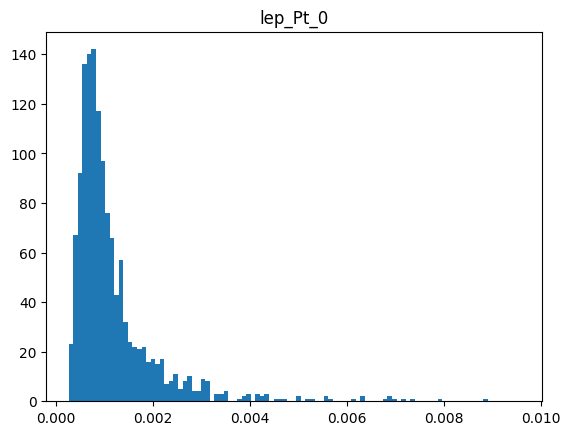

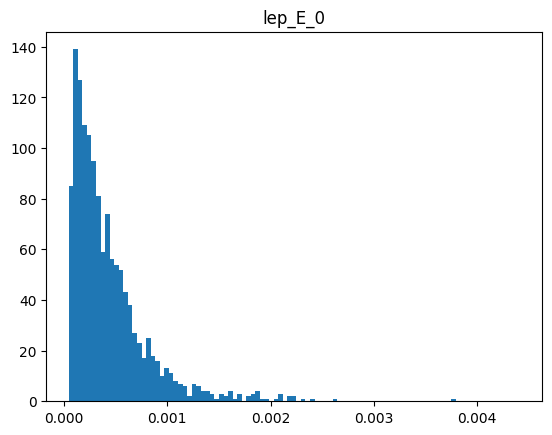

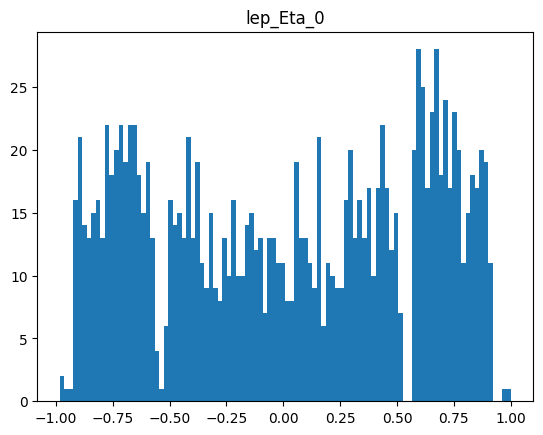

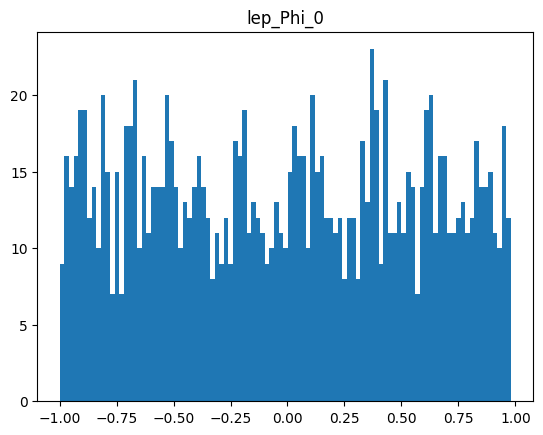

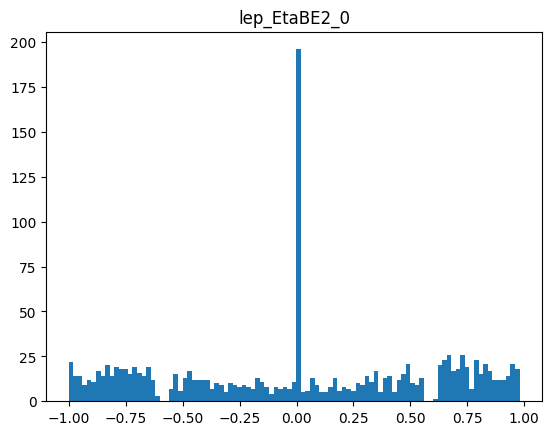

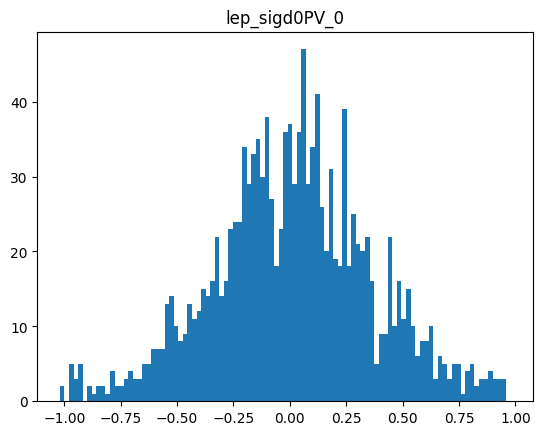

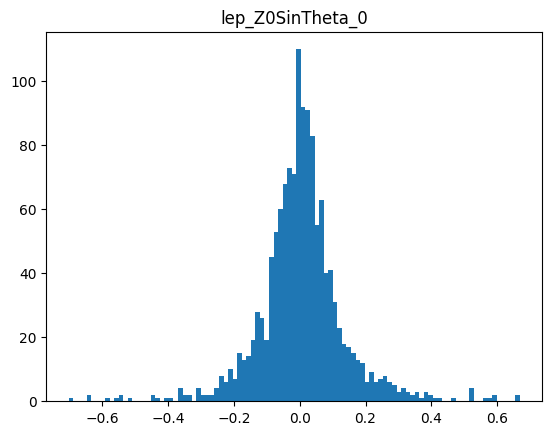

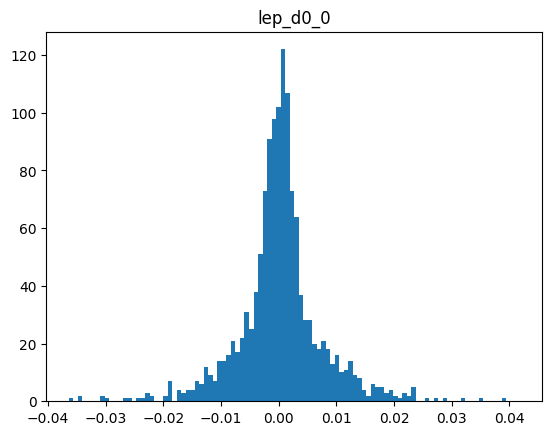

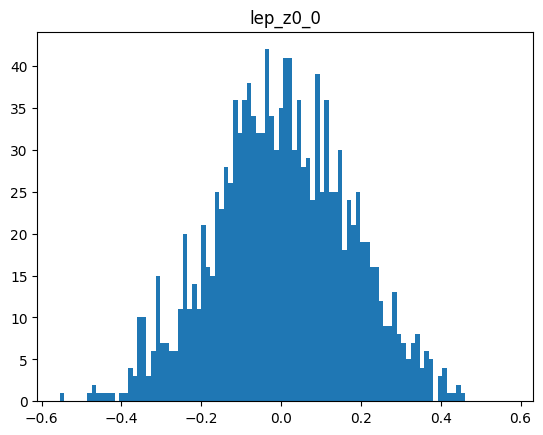

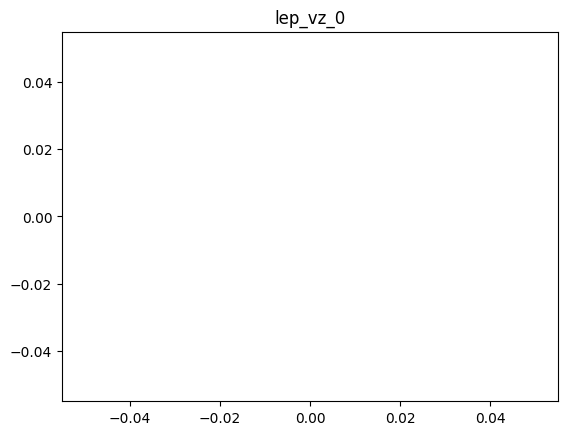

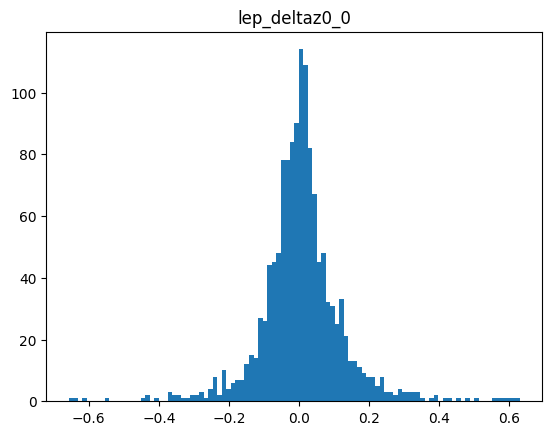

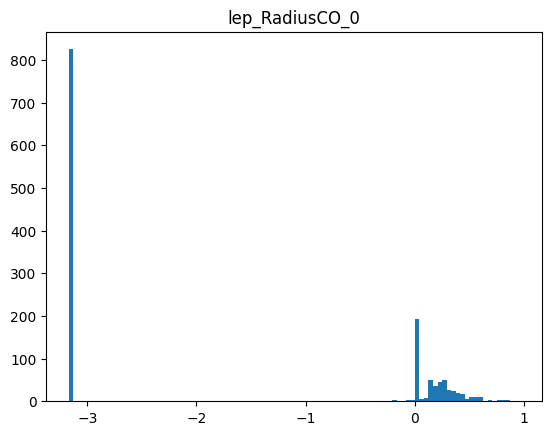

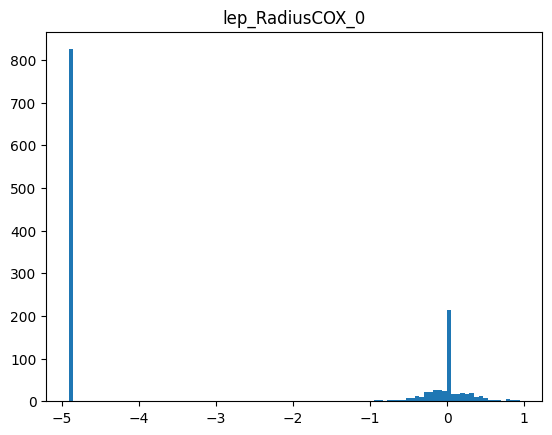

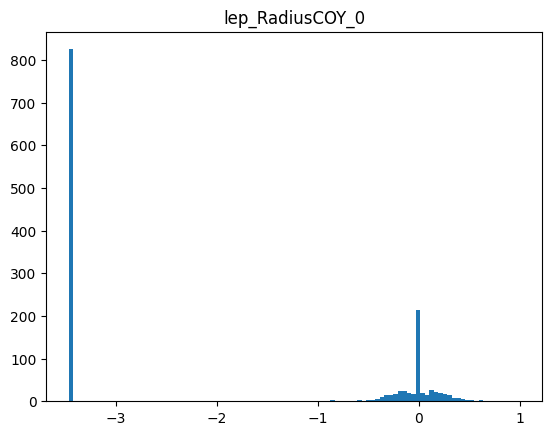

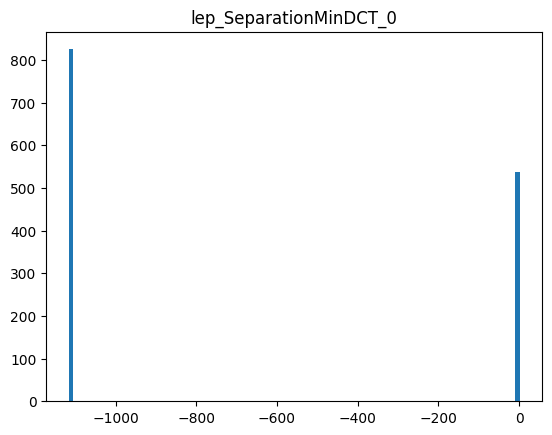

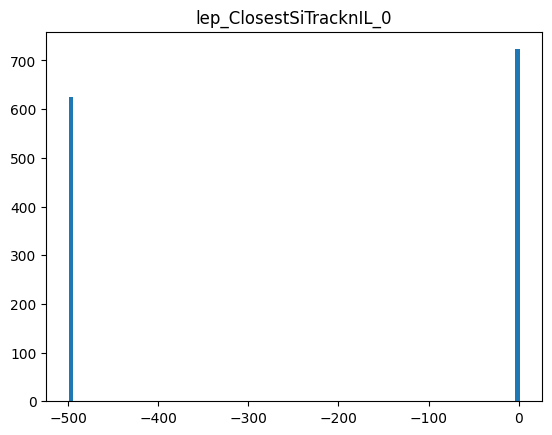

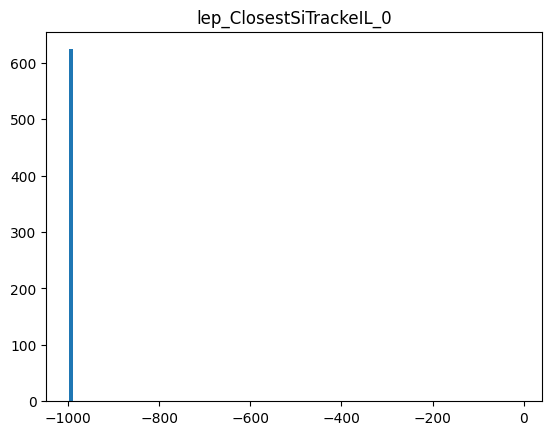

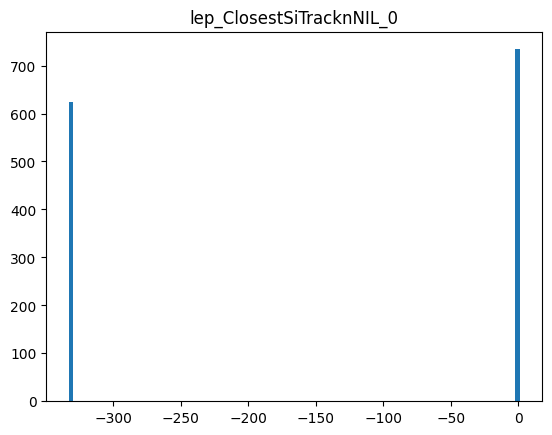

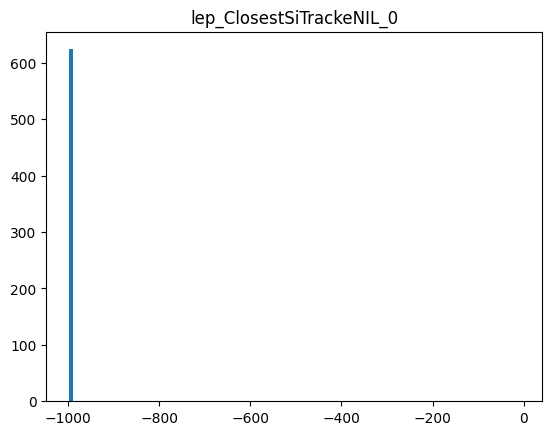

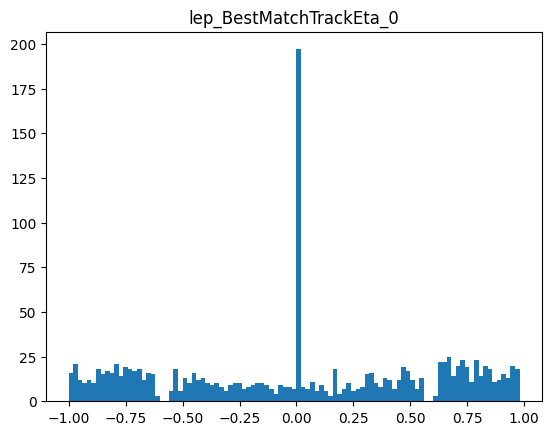

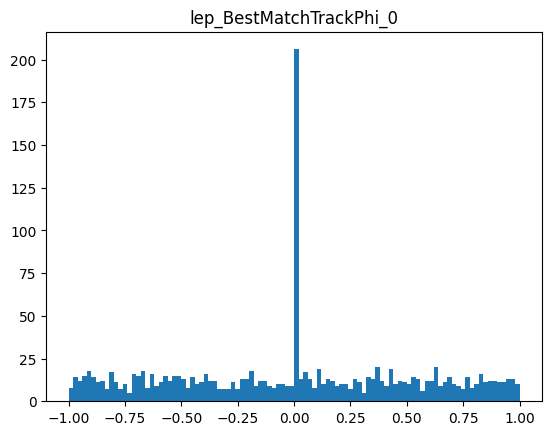

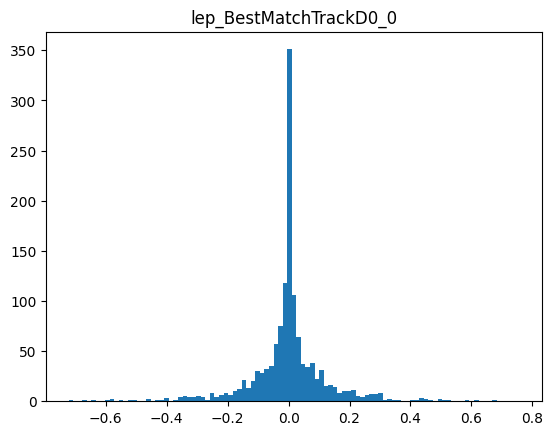

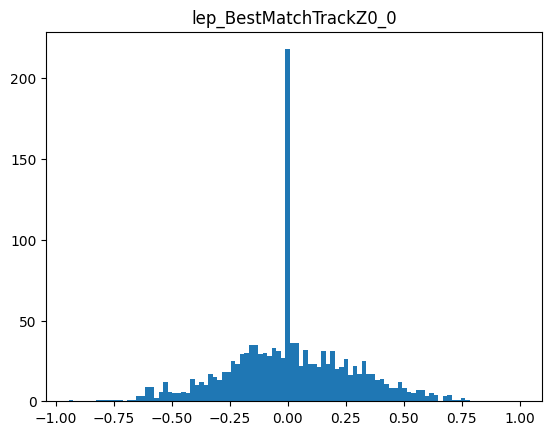

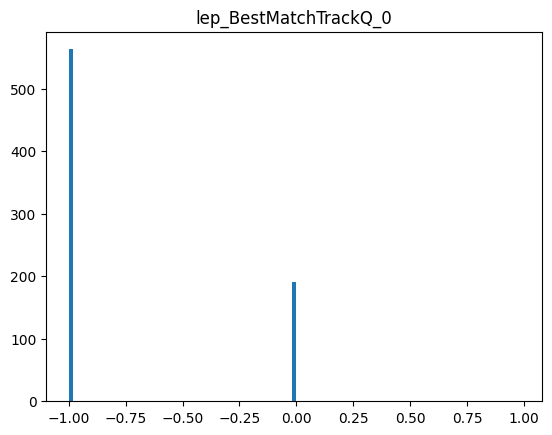

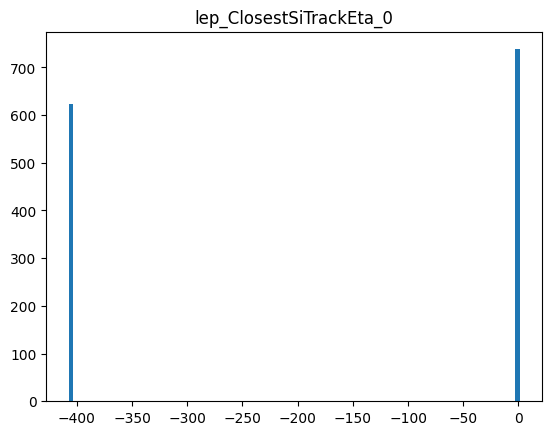

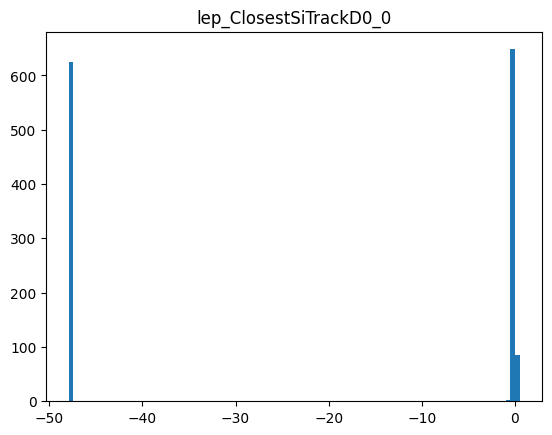

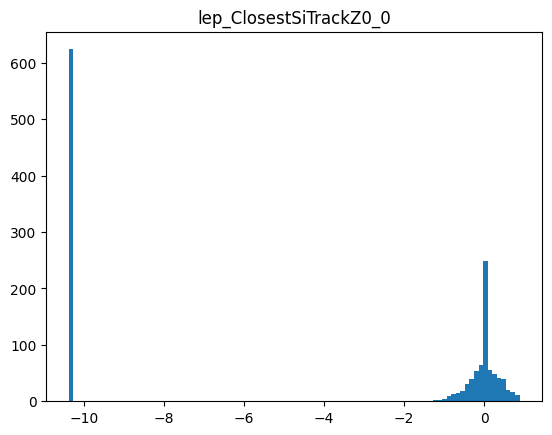

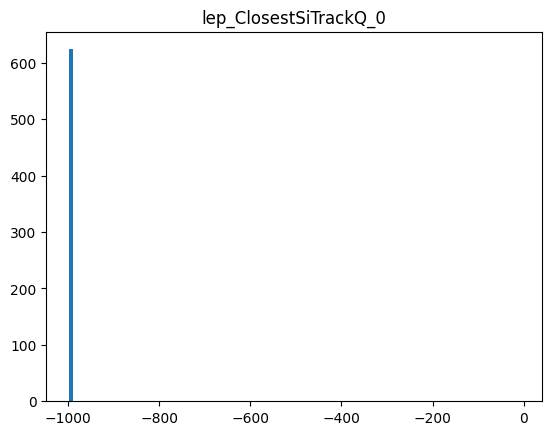

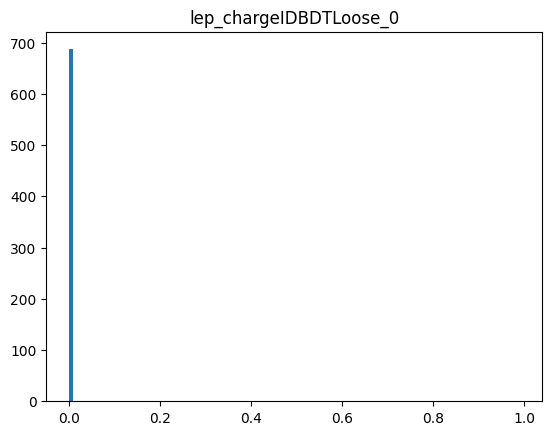

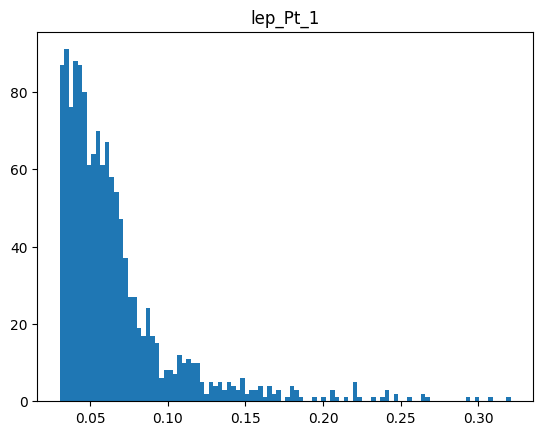

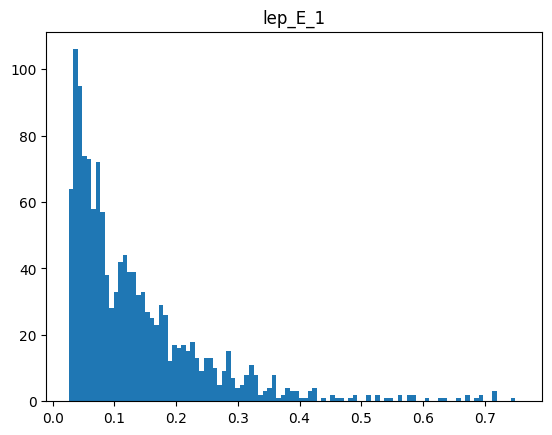

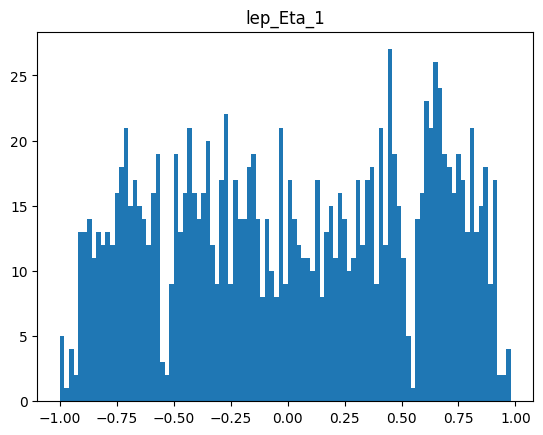

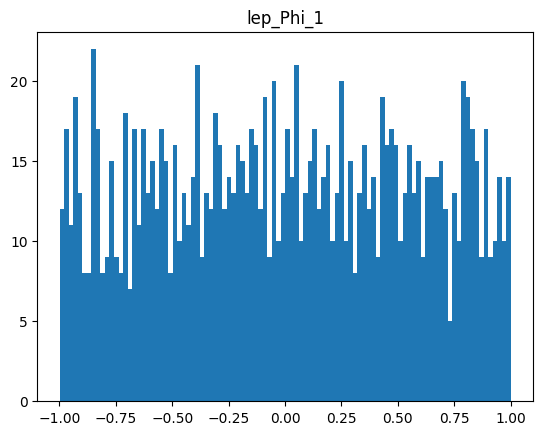

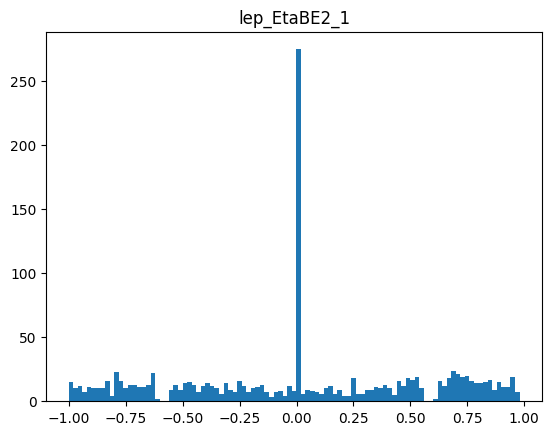

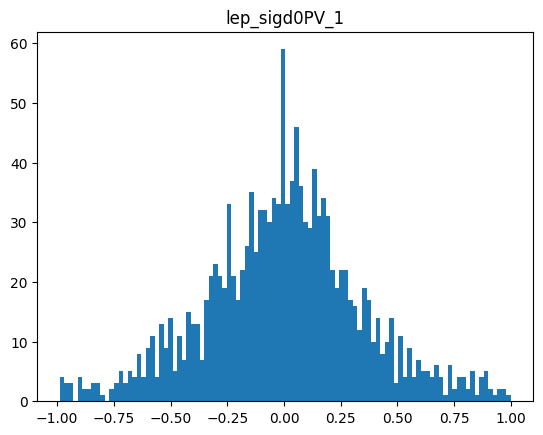

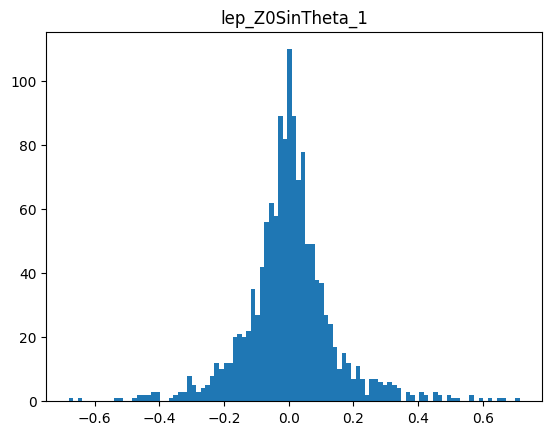

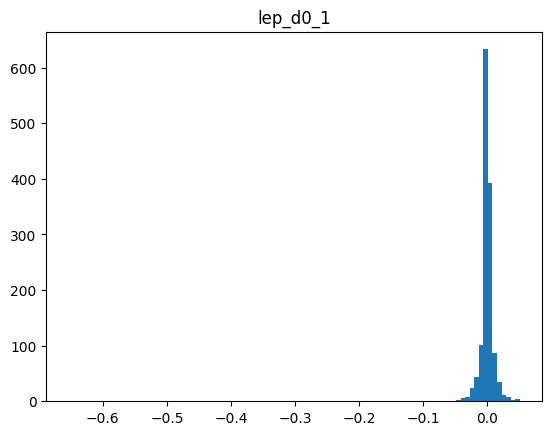

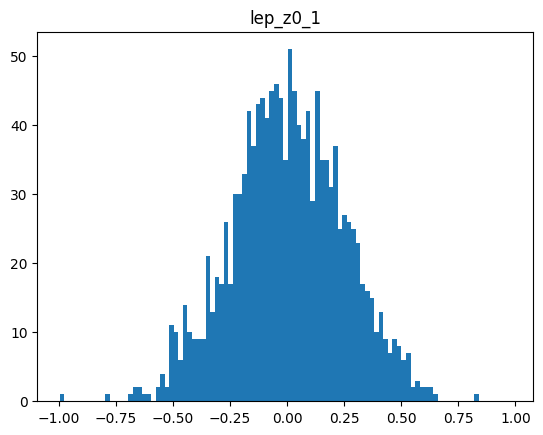

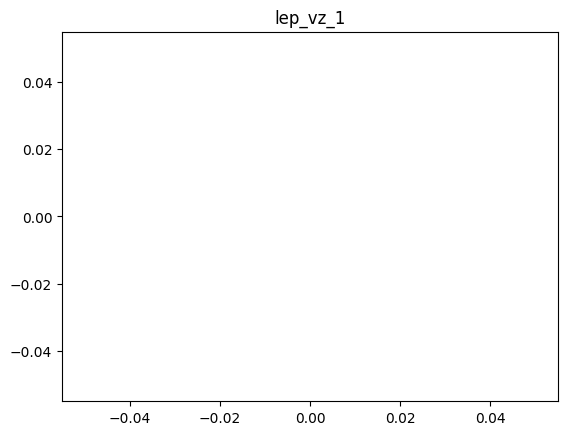

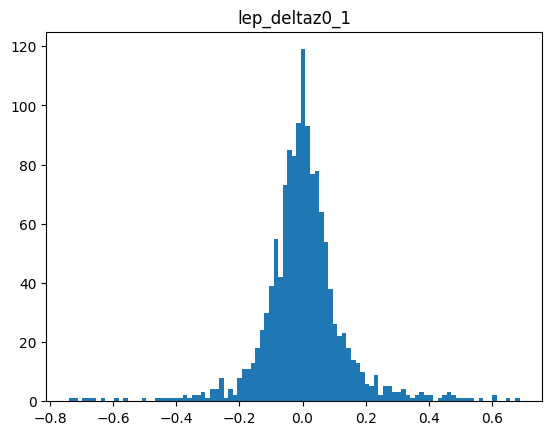

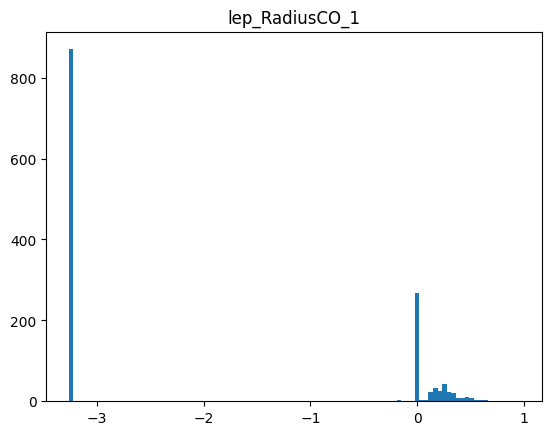

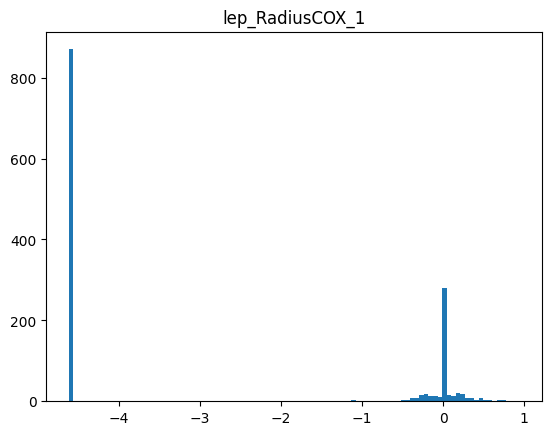

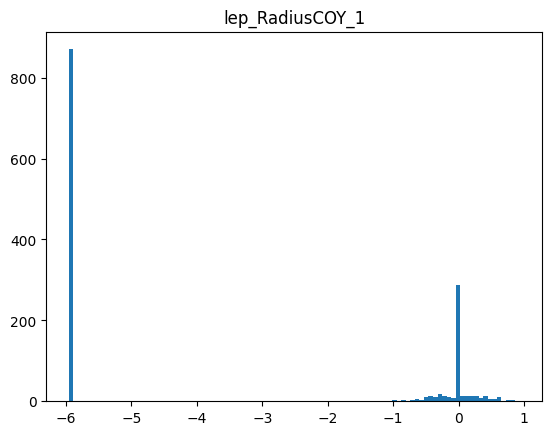

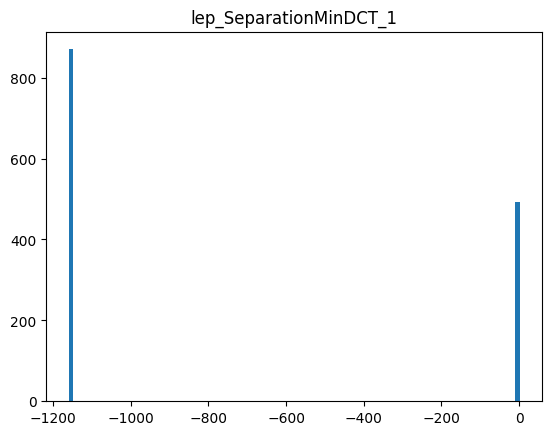

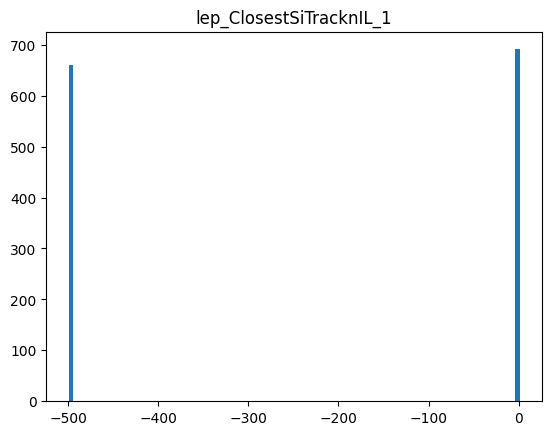

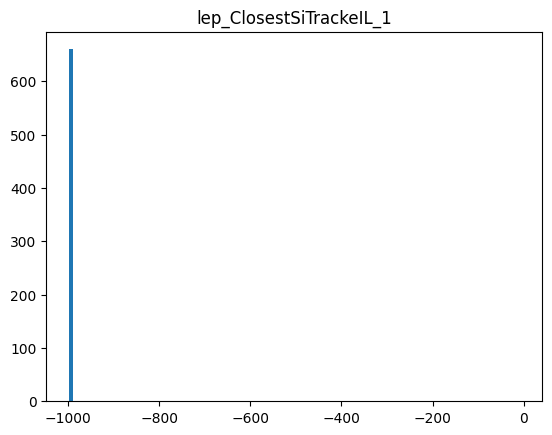

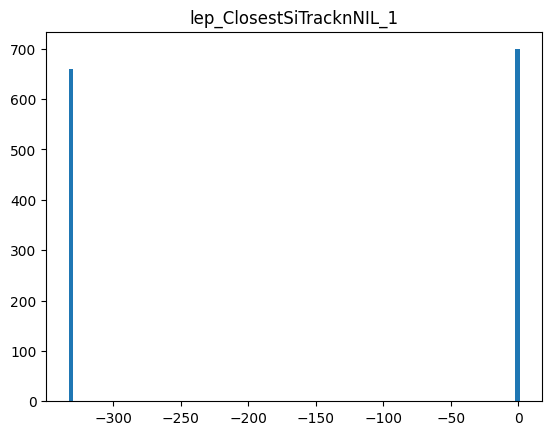

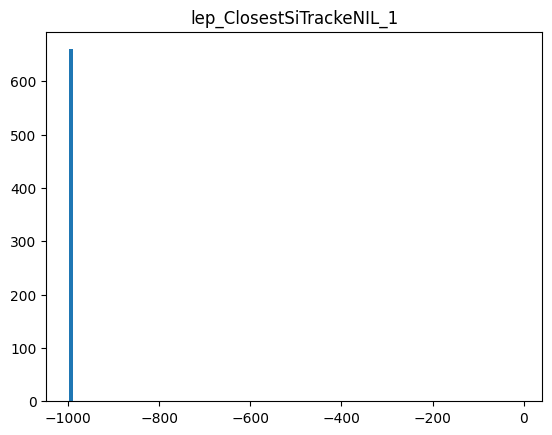

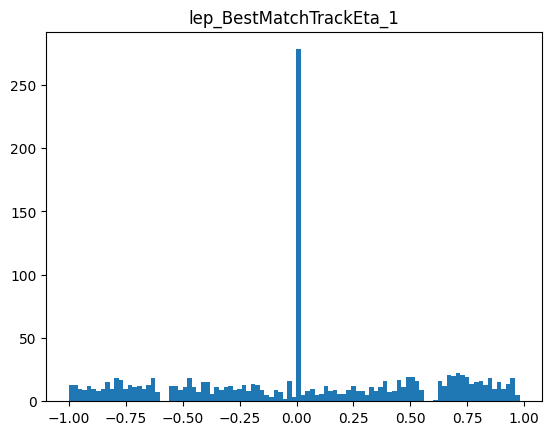

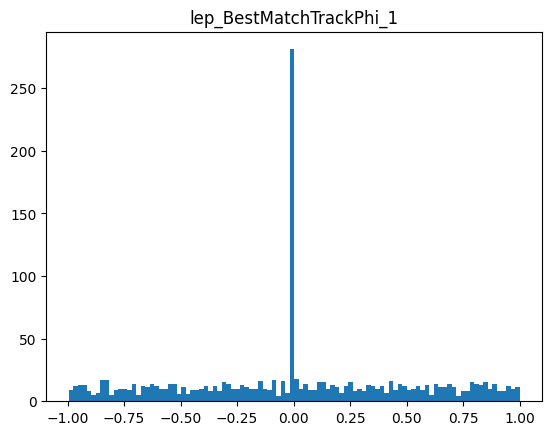

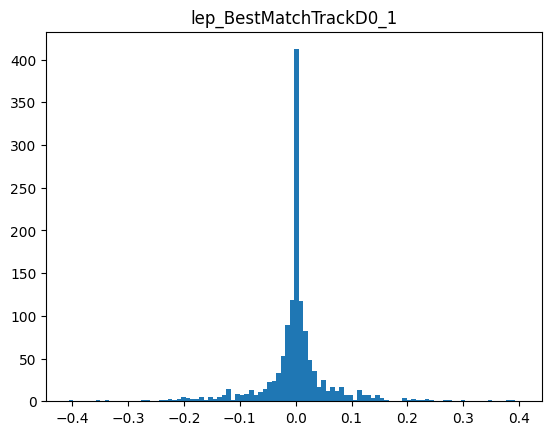

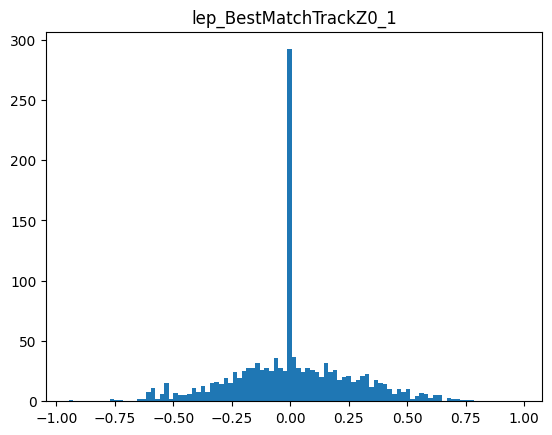

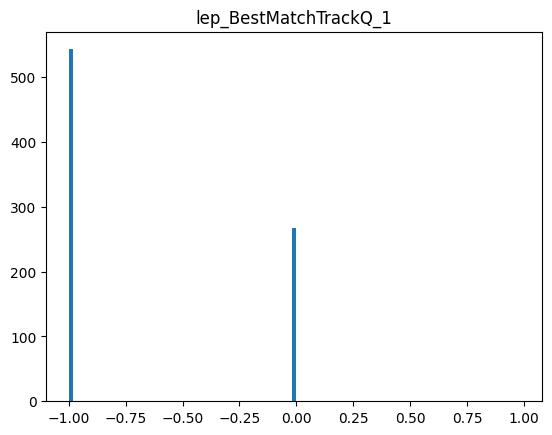

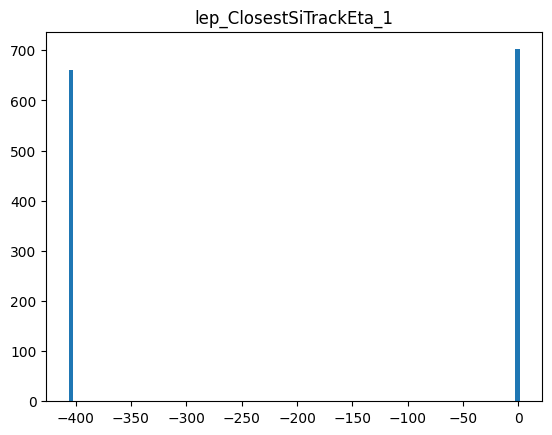

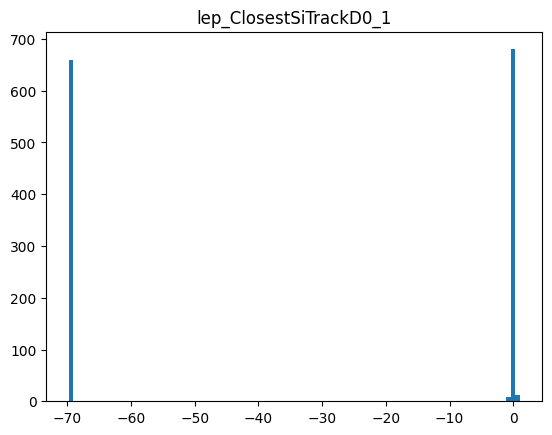

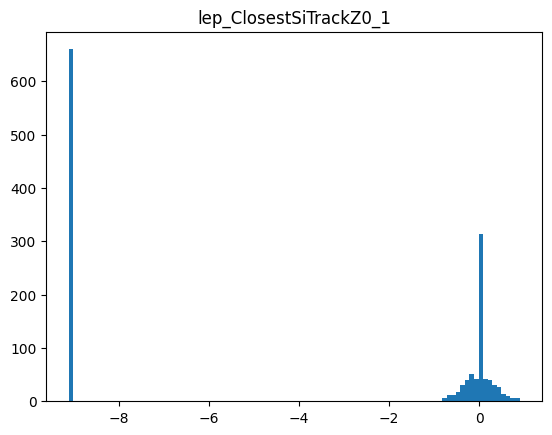

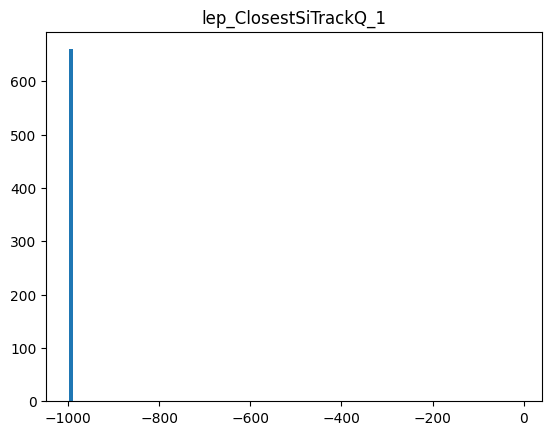

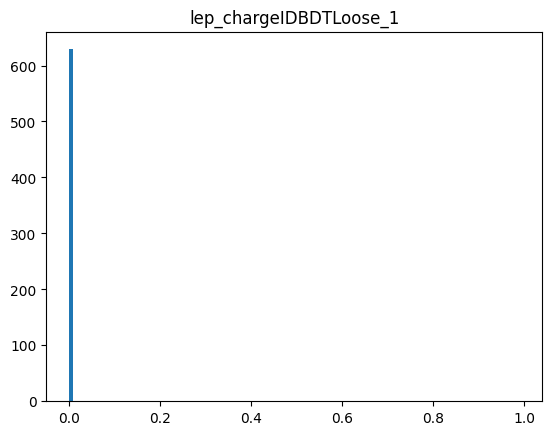

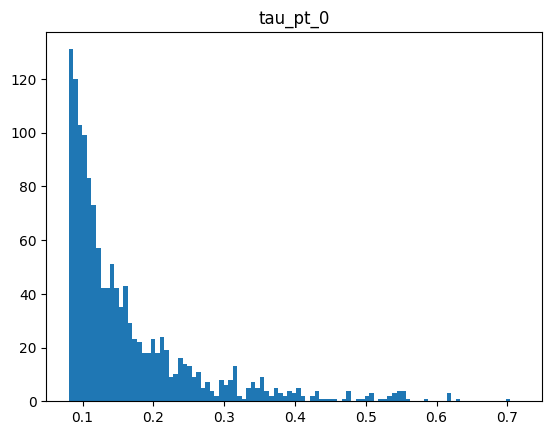

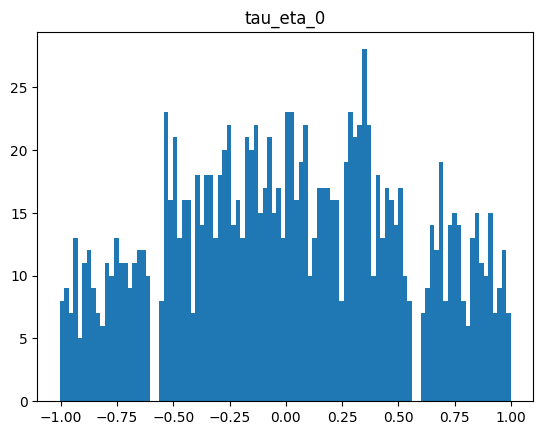

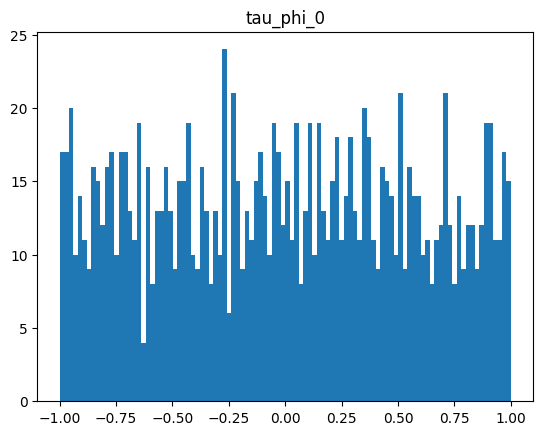

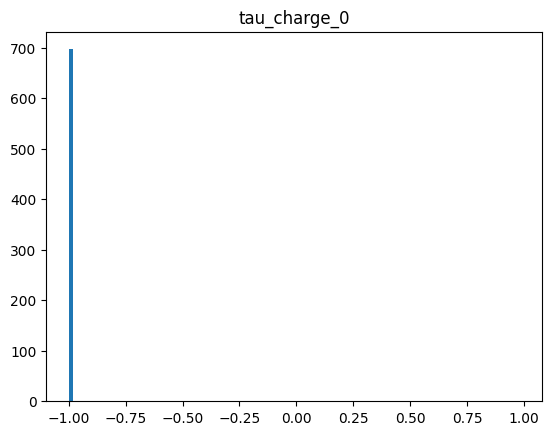

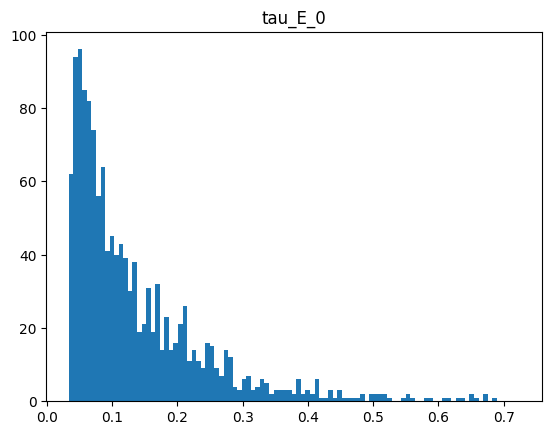

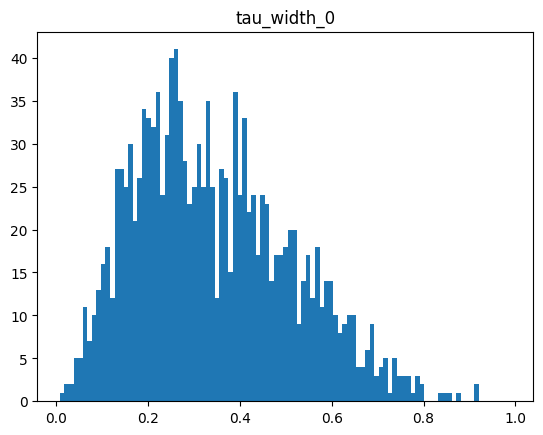

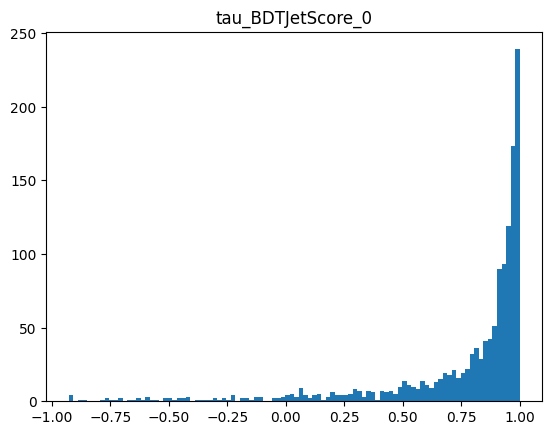

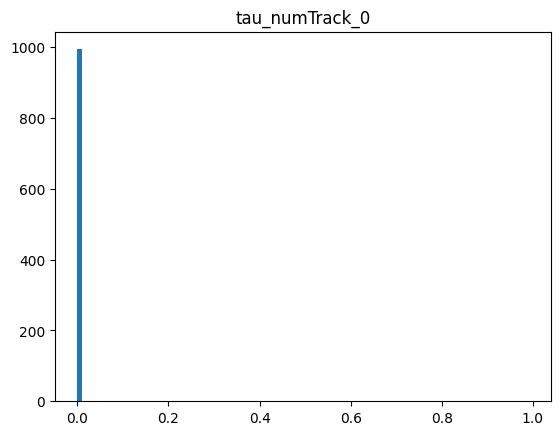

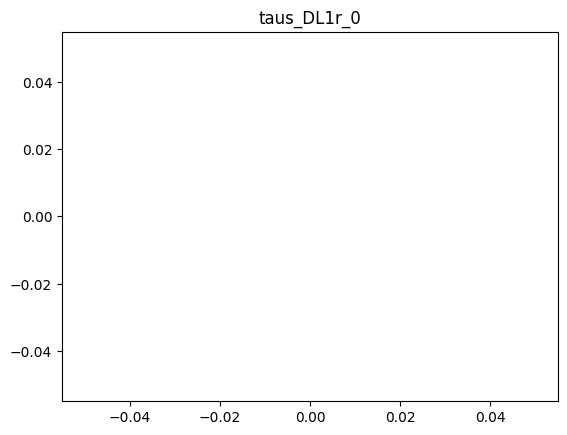

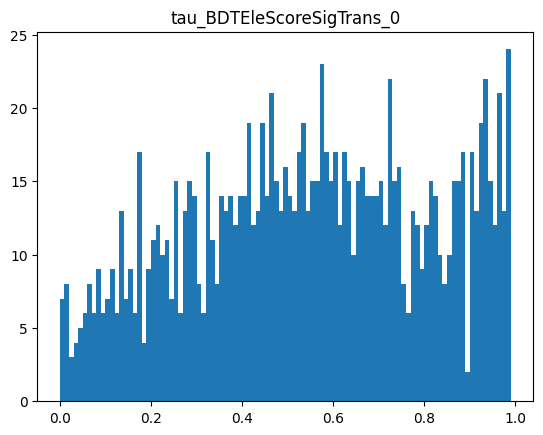

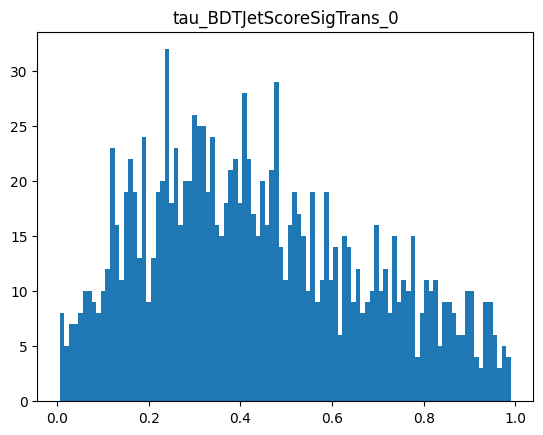

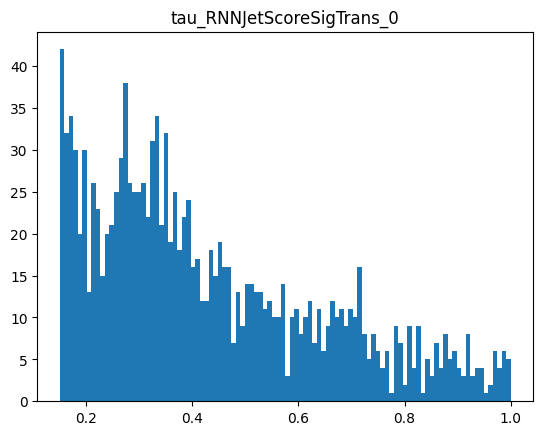

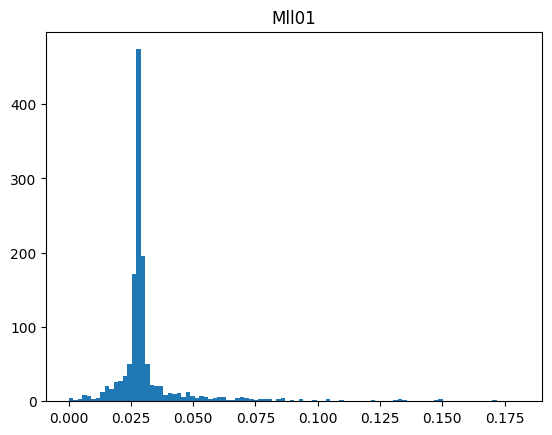

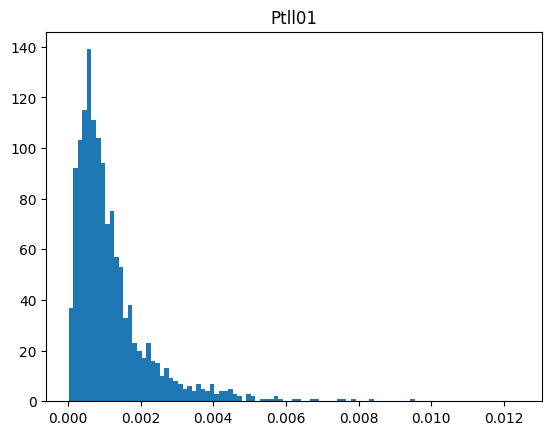

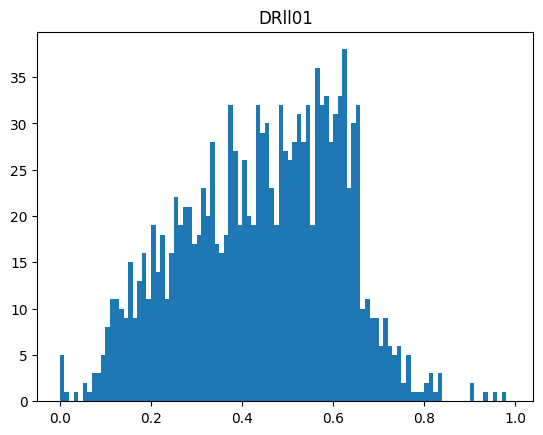

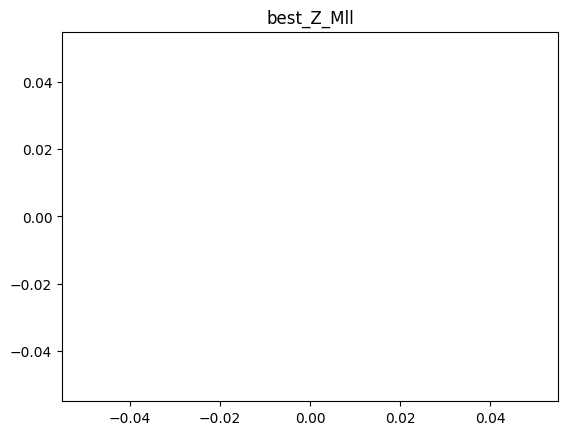

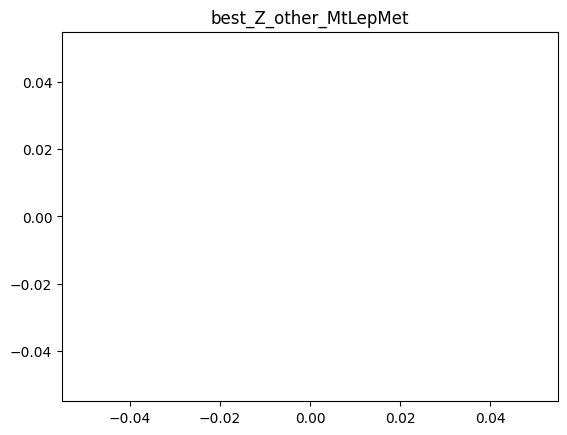

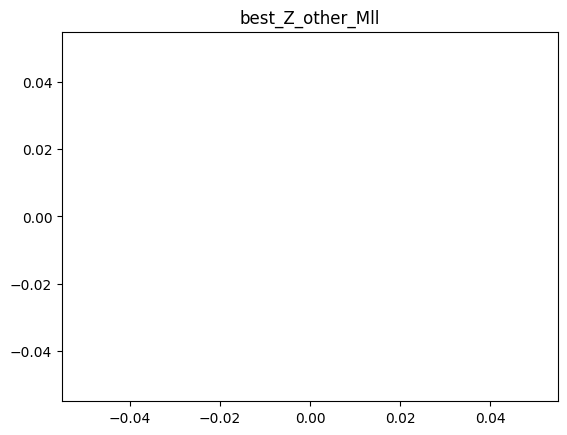

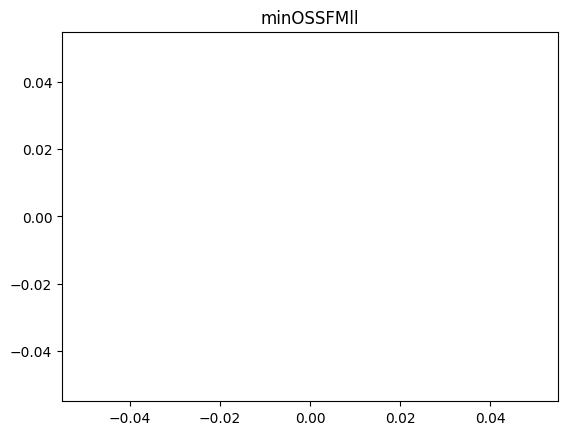

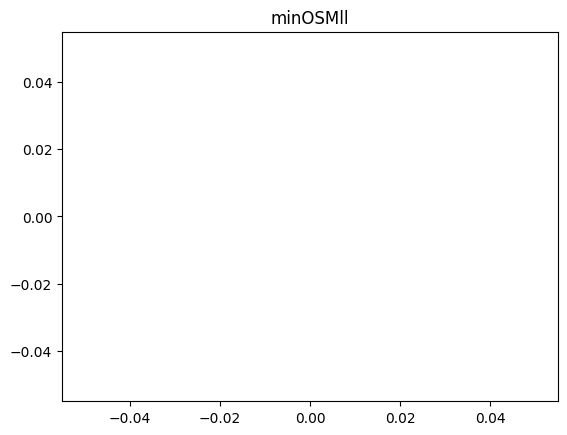

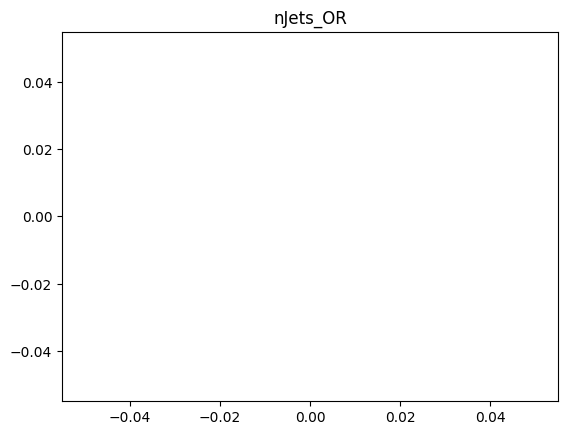

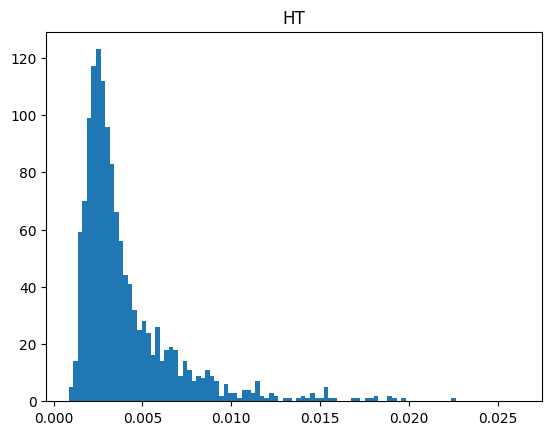

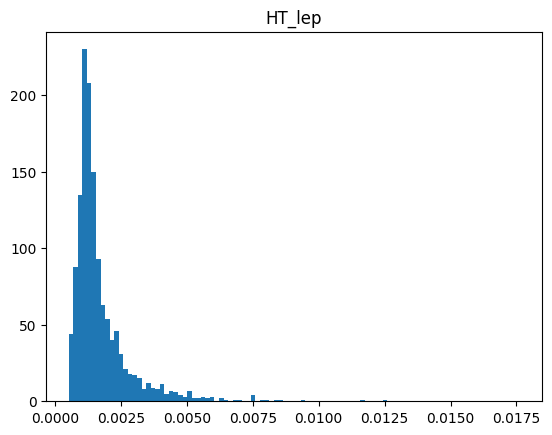

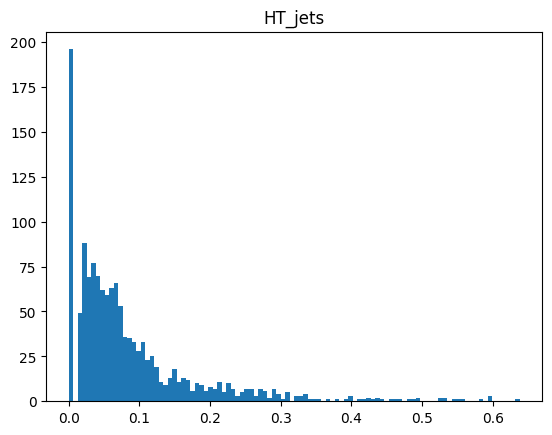

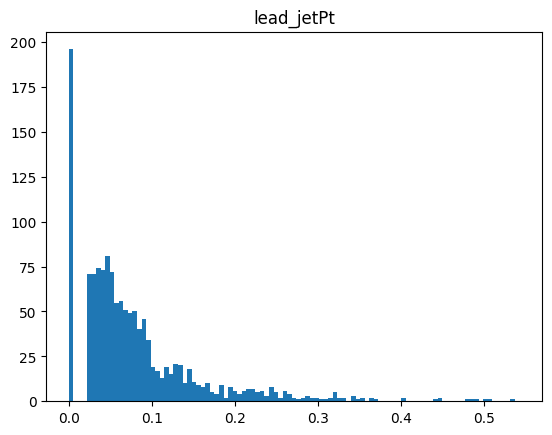

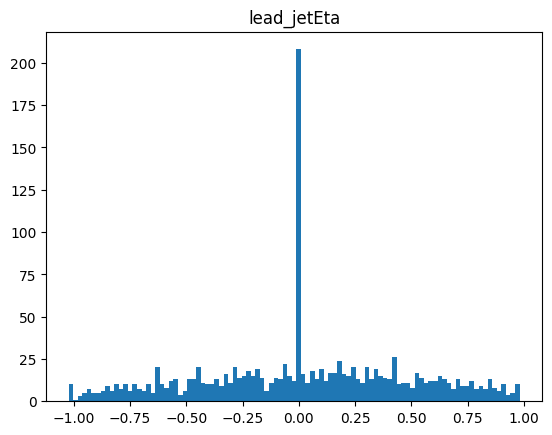

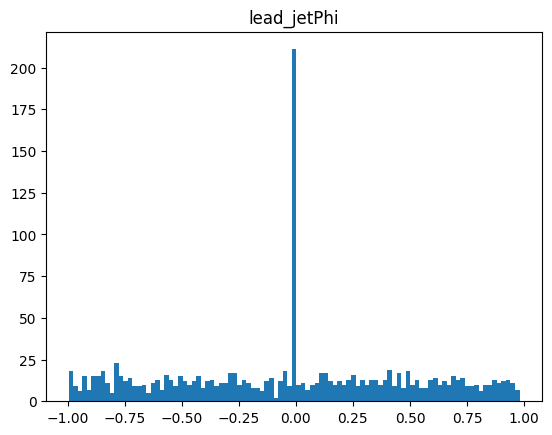

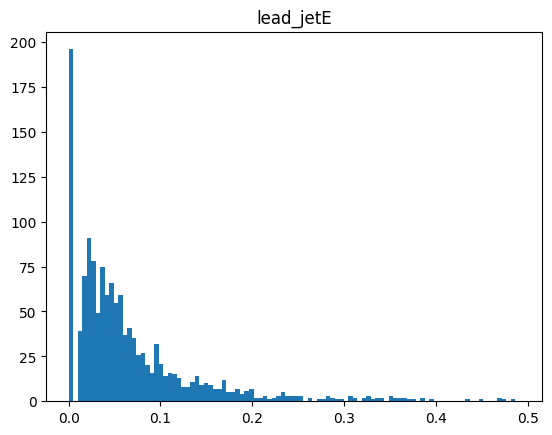

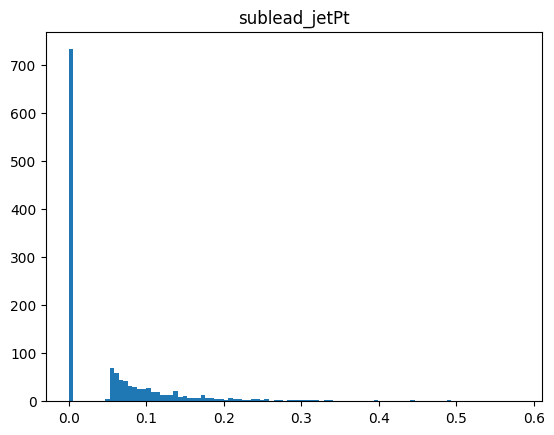

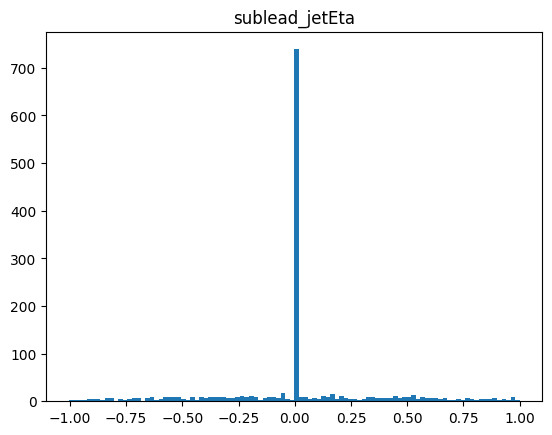

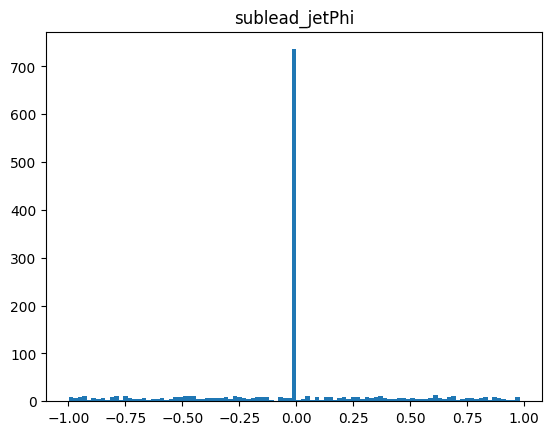

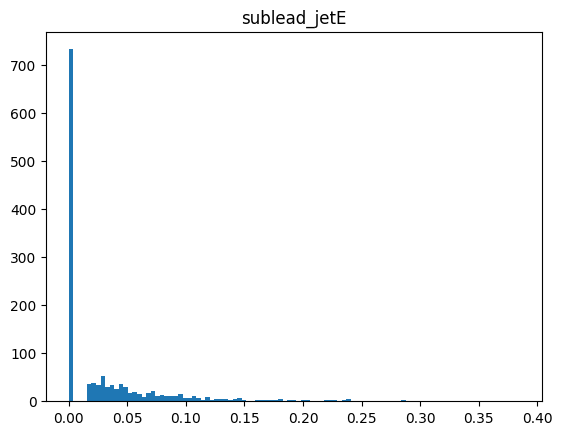

In [276]:
for i in range(0,90):
    paint(keys[i], 100, combined_data[keys[i]])

In [277]:
globals_min

{'lep_Pt_0': 0.0002683923,
 'lep_E_0': 4.4116325e-05,
 'lep_Eta_0': -0.98197395,
 'lep_Phi_0': -0.9987845,
 'lep_EtaBE2_0': -1.0016998,
 'lep_sigd0PV_0': -1.0192808,
 'lep_Z0SinTheta_0': -0.804972,
 'lep_d0_0': -0.37499622,
 'lep_z0_0': -0.5542974,
 'lep_vz_0': 0.0,
 'lep_deltaz0_0': -0.7346345,
 'lep_RadiusCO_0': -3.1706495,
 'lep_RadiusCOX_0': -4.9140735,
 'lep_RadiusCOY_0': -3.4673417,
 'lep_SeparationMinDCT_0': -1116.3794,
 'lep_ClosestSiTracknIL_0': -499.5,
 'lep_ClosestSiTrackeIL_0': -999.0,
 'lep_ClosestSiTracknNIL_0': -333.0,
 'lep_ClosestSiTrackeNIL_0': -999.0,
 'lep_BestMatchTrackEta_0': -1.0008969,
 'lep_BestMatchTrackPhi_0': -1.0004464,
 'lep_BestMatchTrackD0_0': -0.839503,
 'lep_BestMatchTrackZ0_0': -0.94441986,
 'lep_BestMatchTrackQ_0': -1.0,
 'lep_ClosestSiTrackEta_0': -407.48422,
 'lep_ClosestSiTrackD0_0': -47.92997,
 'lep_ClosestSiTrackZ0_0': -10.381496,
 'lep_ClosestSiTrackQ_0': -999.0,
 'lep_chargeIDBDTLoose_0': 0,
 'lep_Pt_1': 0.030588018,
 'lep_E_1': 0.025782332,
 

In [278]:
globals_max

{'lep_Pt_0': 1.0,
 'lep_E_0': 1.0,
 'lep_Eta_0': 1.0,
 'lep_Phi_0': 1.0,
 'lep_EtaBE2_0': 1.0,
 'lep_sigd0PV_0': 1.0,
 'lep_Z0SinTheta_0': 0.804467,
 'lep_d0_0': 1.0,
 'lep_z0_0': 1.0,
 'lep_vz_0': 0.0,
 'lep_deltaz0_0': 0.86668026,
 'lep_RadiusCO_0': 1.0,
 'lep_RadiusCOX_0': 1.0,
 'lep_RadiusCOY_0': 1.0,
 'lep_SeparationMinDCT_0': 1.0,
 'lep_ClosestSiTracknIL_0': 1.0,
 'lep_ClosestSiTrackeIL_0': 1.0,
 'lep_ClosestSiTracknNIL_0': 1.0,
 'lep_ClosestSiTrackeNIL_0': 1.0,
 'lep_BestMatchTrackEta_0': 1.0,
 'lep_BestMatchTrackPhi_0': 1.0,
 'lep_BestMatchTrackD0_0': 0.9453236,
 'lep_BestMatchTrackZ0_0': 1.0,
 'lep_BestMatchTrackQ_0': 1.0,
 'lep_ClosestSiTrackEta_0': 1.0,
 'lep_ClosestSiTrackD0_0': 1.0,
 'lep_ClosestSiTrackZ0_0': 1.0,
 'lep_ClosestSiTrackQ_0': 1.0,
 'lep_chargeIDBDTLoose_0': 1,
 'lep_Pt_1': 0.3291776,
 'lep_E_1': 0.77285105,
 'lep_Eta_1': 1.0,
 'lep_Phi_1': 1.0,
 'lep_EtaBE2_1': 1.0,
 'lep_sigd0PV_1': 1.0,
 'lep_Z0SinTheta_1': 0.784089,
 'lep_d0_1': 0.91819775,
 'lep_z0_1': 1.